In [1]:
import requests
import pandas as pd
import geocoder

In [77]:
%matplotlib inline

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
wikipedia_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikipedia_page = requests.get(wikipedia_link)
wikipedia_doc = wikipedia_page.text

In [3]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(wikipedia_doc, 'html.parser')
table = soup.find('table', {'class': 'wikitable sortable'})

In [4]:
col_names = ["PostalCode", "Borough", "Neighborhood"]
df = pd.read_html(str(table), skiprows=1)
df = pd.DataFrame.from_dict(df[0])
df.columns = col_names
df.head()

,PostalCode,Borough,Neighborhood
0,M2A,Not assigned,Not assigned
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"


In [5]:
df = df[df.Borough != 'Not assigned'].reset_index(drop=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
def combine_neighborhood(series):
    return series.str.cat(sep=', ')

df_by_pcode = df.groupby(["PostalCode", "Borough"])
df = df_by_pcode.agg({'Neighborhood': combine_neighborhood}).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
def impute_neirghborhood(row):
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']
    
    return row

df = df.apply(impute_neirghborhood, axis=1)
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
df.shape

(103, 3)

In [9]:
df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M5V,North York,Downsview
freq,1,24,4


In [10]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [12]:
postal_codes = df['PostalCode']

In [13]:
coords = [get_latilong(postal_code) for postal_code in postal_codes.tolist()]

In [14]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [16]:
df[df.PostalCode == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [17]:
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520
3,M1G,Scarborough,Woburn,43.76820,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944
5,M1J,Scarborough,Scarborough Village,43.74309,-79.23526
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72861,-79.26367
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71406,-79.28412
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69539,-79.26194


In [29]:
from geopy.geocoders import Nominatim

In [41]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='lamkwanyui@gmail.com')
location = geolocator.geocode(address)

In [42]:
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Scarborough,Toronto are 43.773077, -79.257774.


In [43]:
import folium

map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [48]:
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [45]:
# @hiddel_cell
CLIENT_ID = 'DBAVGN2MPCIANGE5FRD2LF44H1SA4G5XYJWA2EIPYC15C0G2'
CLIENT_SECRET = 'L312MM3APCWCYZEVMOWLHOC412305GUXUWHUORUQ53VXVRO2'
VERSION = '20180604'
LIMIT = 30

In [49]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [52]:
from pandas.io.json import json_normalize
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [53]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [54]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929


In [55]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,Hot Topic,Clothing Store,43.775450,-79.257929


In [56]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store            8
Coffee Shop               6
Restaurant                4
Pharmacy                  2
Sandwich Place            2
Tea Room                  2
Gas Station               2
Furniture / Home Store    2
Electronics Store         2
Intersection              1
Name: categories, dtype: int64

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [59]:
Scarborough_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [60]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 302 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,32,32,32,32,32,32
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27


In [61]:
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0  Chinese Restaurant  0.12
1       Shopping Mall  0.06
2         Pizza Place  0.06
3                Bank  0.03
4      Sandwich Place  0.03


---- Alderwood, Long Branch ----
            venue  freq
0            Pool  0.11
1    Dance Studio  0.11
2     Gas Station  0.11
3  Sandwich Place  0.11
4             Gym  0.11


---- Bathurst Manor, Wilson Heights, Downsview North ----
                  venue  freq
0                  Park  0.50
1     Convenience Store  0.25
2  Other Great Outdoors  0.25
3                 Plaza  0.00
4                Museum  0.00


---- Bayview Village ----
              venue  freq
0              Park  0.33
1             Trail  0.33
2  Asian Restaurant  0.33
3       Zoo Exhibit  0.00
4      Music School  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.07
1         Pizza Place  0.07
2  Italian Restaurant  0.07
3      Sandwich Place  0.07
4          Restaurant  

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Pizza Place,Shopping Mall,Discount Store,Bakery,Bank,Sushi Restaurant,Supermarket,Latin American Restaurant,Sandwich Place
1,"Alderwood, Long Branch",Pizza Place,Gas Station,Pool,Pharmacy,Pub,Sandwich Place,Coffee Shop,Gym,Dance Studio,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Convenience Store,Other Great Outdoors,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
3,Bayview Village,Asian Restaurant,Park,Trail,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Pizza Place,Restaurant,Sandwich Place,Pharmacy,Sports Club,Thai Restaurant,Sushi Restaurant,Liquor Store


In [66]:
from sklearn.cluster import KMeans
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

In [67]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df.iloc[:16,:]

Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552,1,Zoo Exhibit,Fast Food Restaurant,Paintball Field,Construction & Landscaping,History Museum,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871,1,Fish & Chips Shop,Bar,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520,2,Park,Athletics & Sports,Gym / Fitness Center,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
3,M1G,Scarborough,Woburn,43.76820,-79.21761,1,Chinese Restaurant,Fast Food Restaurant,Park,Coffee Shop,Yoga Studio,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944,1,Flower Shop,Indian Restaurant,Caribbean Restaurant,Thai Restaurant,Gas Station,Athletics & Sports,Bank,Hakka Restaurant,Bakery,Farm


In [68]:
kclusters = 10

In [71]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [72]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [74]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [75]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

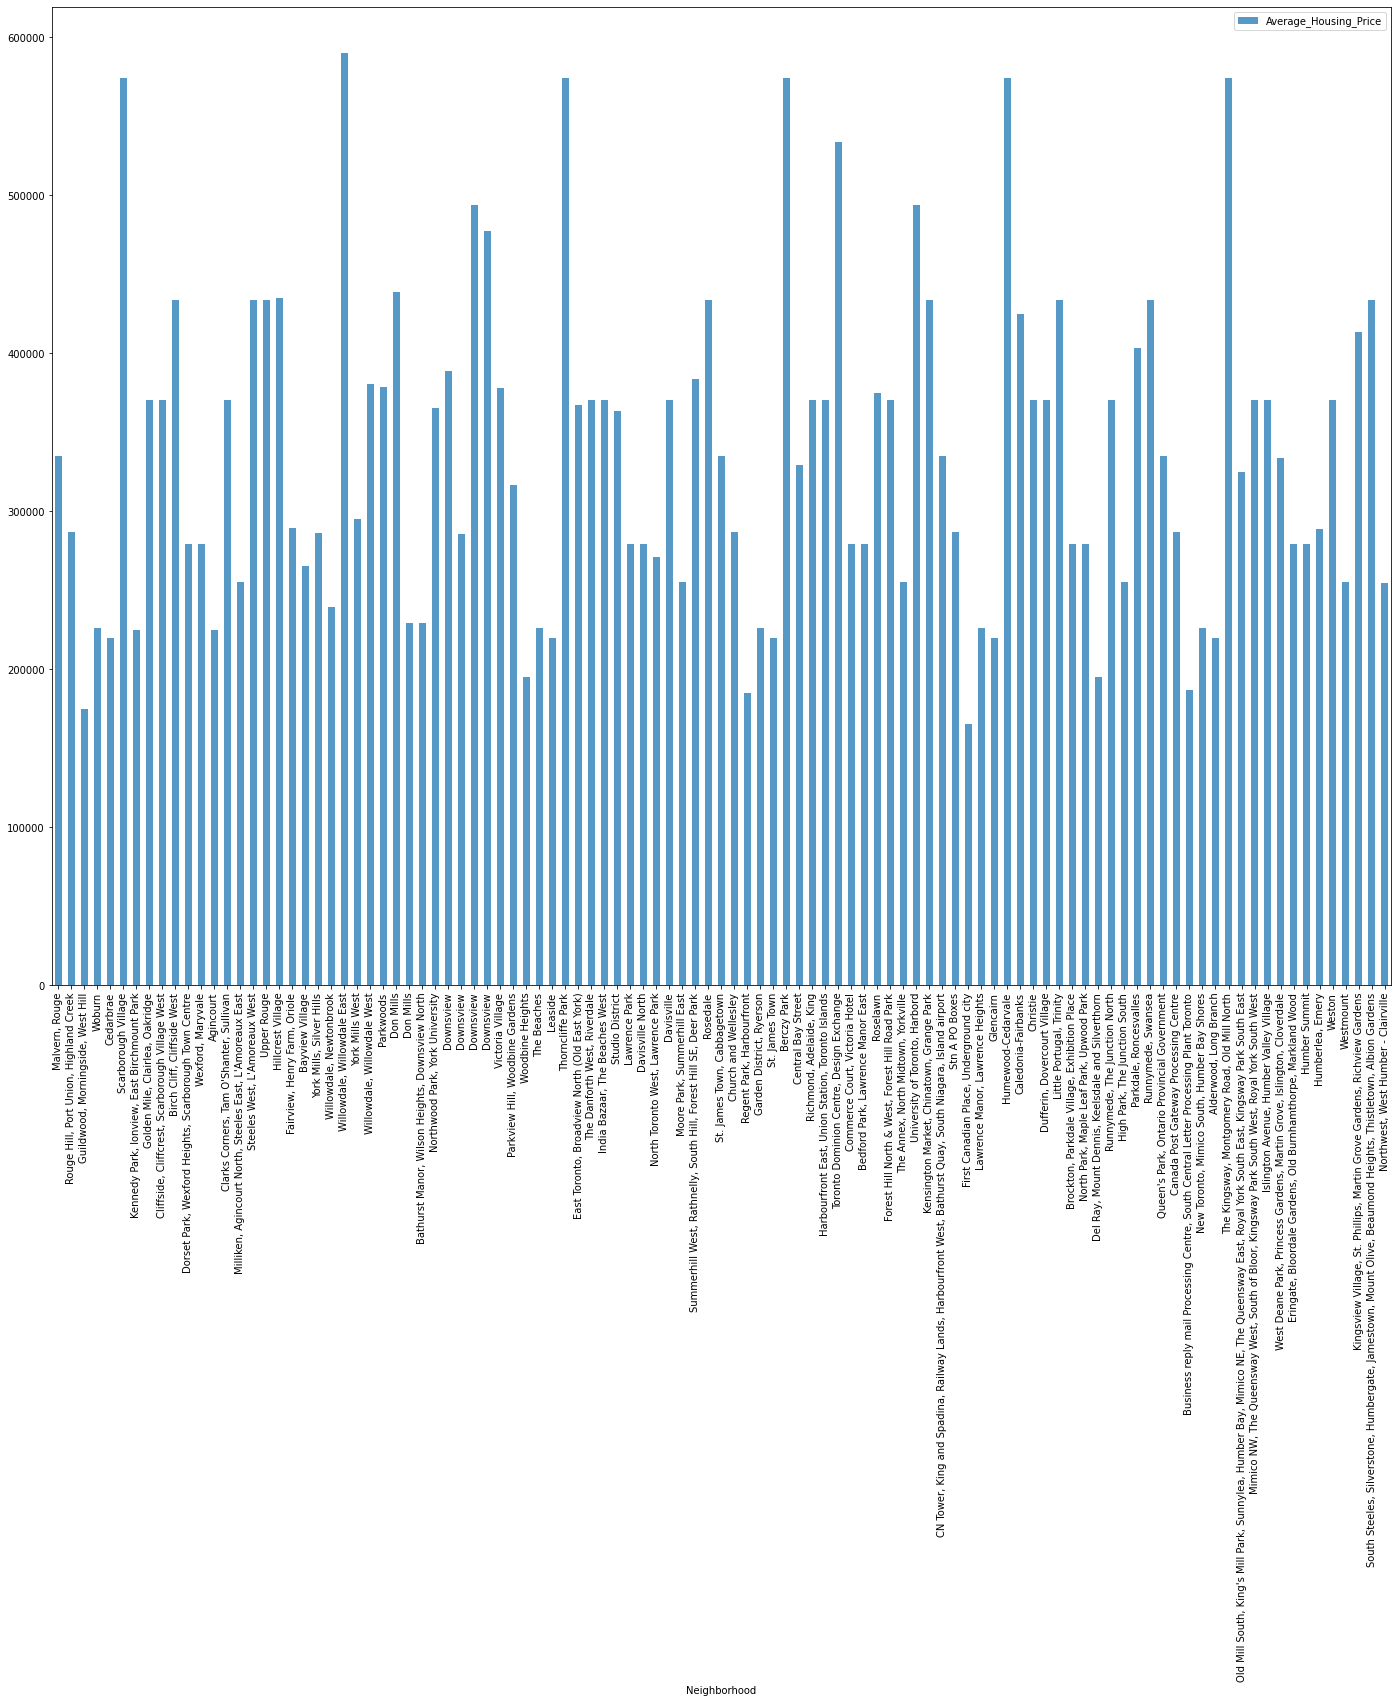

In [76]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [78]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [79]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [80]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

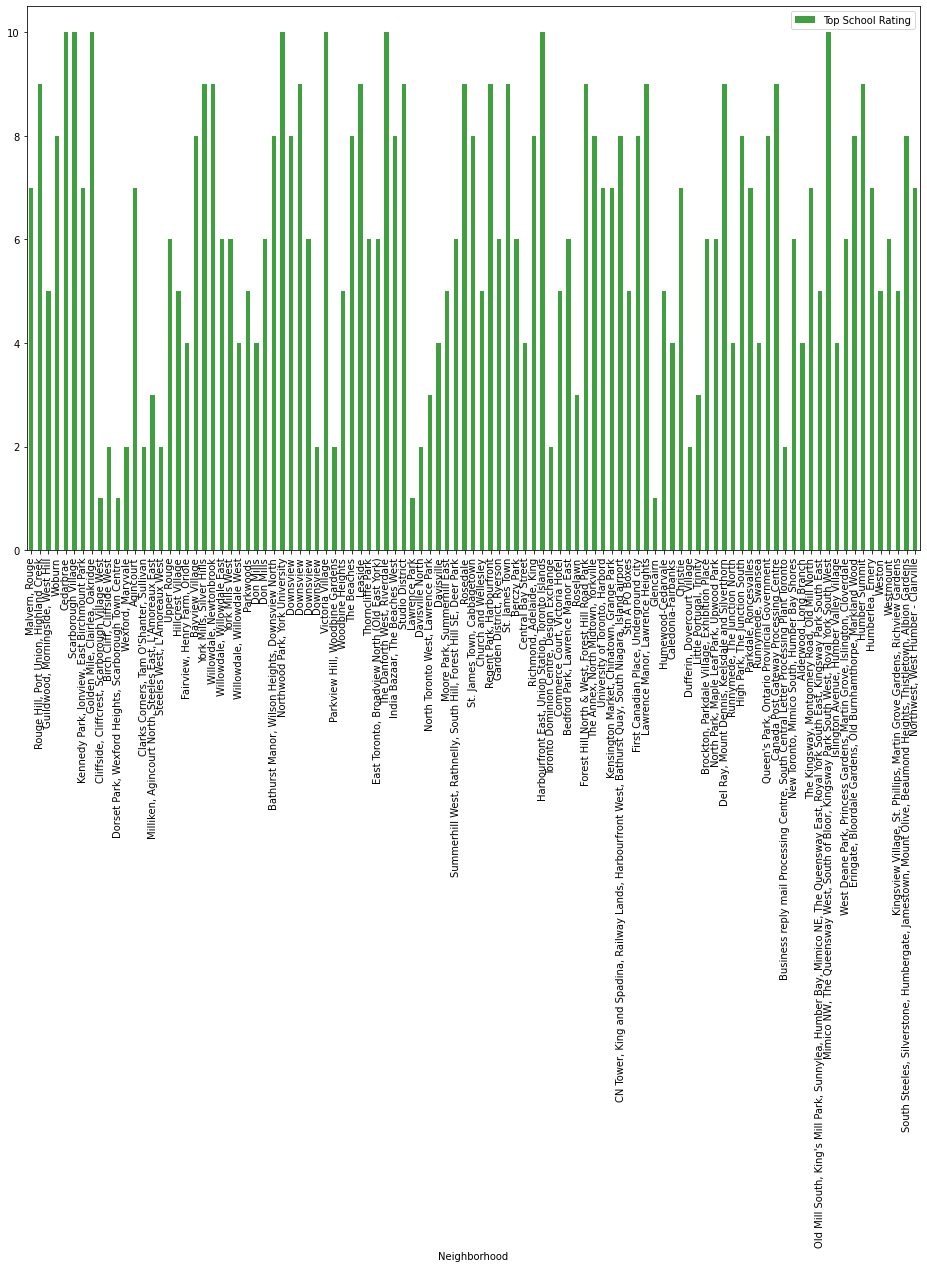

In [81]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);